In [2]:
import timeit
import os
import sys
import numpy as np
import pylab
import seaborn
seaborn.set_style("white")
import scipy.interpolate
from IPython.display import clear_output
import matplotlib.pyplot as plt
from os import system, name
import time

from pystorm.hal import HAL
from pystorm.PyDriver import bddriver as bd
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal import data_utils
from pystorm.hal.run_control import RunControl
from pystorm.hal.neuromorph import graph
import tempy as tp
import measure_utils as ut

# Prepare Several Pool Sizes

##### Goal: Measure Tuning Curves for Pools Sizes: 8x8, 10x10, 16x16, 22x22, 32x32, 44x44

In [3]:
# Folder Path for these Measurements
path = 'less_clobber0/'
specs_path = path + 'specs/'
cals_path = path + 'cals/'
meas_path = path + 'meas/'
if (not os.path.isdir(path)):
    os.mkdir(path)
if (not os.path.isdir(specs_path)):
    os.mkdir(specs_path)
if (not os.path.isdir(cals_path)):
    os.mkdir(cals_path)
if (not os.path.isdir(meas_path)):
    os.mkdir(meas_path)

# Temperature Cycle Information
ROOM_TEMP = 26.0 # Where twiddle bits are calibrated
MAX_TEMP = 38.0
MIN_TEMP = 0.0
R = 50    # Number of measured temperatures
MEAS_TS = np.linspace(MAX_TEMP, MIN_TEMP, R)
np.save(specs_path + 'R', R)
np.save(specs_path + 'Tarr', MEAS_TS)

# Pool Specifications for multiple pools
N_pools = 6
D = 1
Xs = np.array([8,10,16,22,32,44])
Ys = np.array([8,10,16,22,32,44])
N_neurs = Xs*Ys
LY, LX = (0,0)
pool_ids = np.array(['8x8', '10x10', '16x16', '22x22', '32x32', '44x44'])
np.save(specs_path + 'Xs', Xs)
np.save(specs_path + 'Ys', Ys)
np.save(specs_path + 'N_neurs', N_neurs)
np.save(specs_path + 'N_pools', N_pools)
np.save(specs_path + 'pool_ids', pool_ids)

# Tuning Curve Settings
Q = 100    # Number of sampled input frequencies
HOLD_TIME = 2
SAMPLE_PTS = np.linspace(-1, 1, Q).reshape((Q,1))
np.save(specs_path + 'Q', Q)
np.save(specs_path + 'HOLD_TIME', HOLD_TIME)
np.save(specs_path + 'x_in', SAMPLE_PTS)

exp_time = R*(Q*N_pools*HOLD_TIME) + (MAX_TEMP - MIN_TEMP)*40
print('Collecting tuning curves for ' + str(N_pools) + ' Pool Sizes at ' + str(R) + ' Temperatures and ' + str(Q) + ' Input Values')
print("Expected Measurement Time: " + str(exp_time/60) + " min")
print(str(exp_time/3600) + " hours")

INST = ut.open_connection()

Expected Measurement Time: 1025.3333333333333 min
17.08888888888889 hours
Connected to TestEquity M106 with port 502


In [4]:
# # Go to room temperature for initial calibration
# timeout = True
# print("Going to Room Temperature")
# while(timeout):
#     timeout, avg_temp, std_temp = ut.set_temp(ROOM_TEMP, INST)
# print()

PS = []
DAC = []
for ind, pid in enumerate(pool_ids):
    print('Calibration for pool ' + pid)
    ps, dacs, hal = ut.initialize_and_calibrate(Ys[ind], Xs[ind], LY, LX)
    PS.append(ps)
    DAC.append(dacs)
    clear_output()
    np.save(cals_path + 'biases_' + pid, ps.biases)
    np.save(cals_path + 'fmax_' + pid, ps.fmax)
    np.save(cals_path + 'TPM_' + pid, ps.TPM)
    np.save(cals_path + 'dacs_' + pid, dacs)
print('Done with initial Calibration!')

Done with initial Calibration!


In [6]:
# Save initial empty tuning curve matrices:
for ind, pid in enumerate(pool_ids):
    A = np.ndarray((Q, N_neurs[ind], R))
    np.save(meas_path + 'A_' + pid, A)

# Have we measured this temperature already?
measured = [False]*R

In [7]:
for r, Tset in enumerate(MEAS_TS):
    if (not measured[r]):
        print(str(np.sum(measured)/R*100) + "% completed")

        print("Setting temperature to " + str(Tset) + " C")
        timeout = True
        counter = 0
        while(timeout):
            timeout, avg_temp, std_temp = ut.set_temp(Tset, INST)
            counter += 1
            if (counter > 3):
                timeout = False
        for ind, pid in enumerate(pool_ids):
            ps = PS[ind]
            dac = DAC[ind]
            hal = HAL()
            print("Measuring " + pid + " at " + str(Tset) + ' C')
            A_new, fs_new = ut.measure_tuning_curves(hal, ps, SAMPLE_PTS, dacs = dacs, training_hold_time = HOLD_TIME)
            
            A = np.load(meas_path + 'A_' + pid + '.npy')
            A[:,:,r] = A_new
            np.save(meas_path + 'A_' + pid, A)
            np.save(meas_path + 'fs_' + pid, fs_new)
        measured[r] = True

0.0% completed
Setting temperature to 38.0 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 38.0 C
Average Temp is 37.96+-0.018 C
Measuring 8x8 at 38.0 C
1 --> 1
Calling Map
Measuring 10x10 at 38.0 C
1 --> 1
Calling Map
Measuring 16x16 at 38.0 C
1 --> 1
Calling Map
Measuring 22x22 at 38.0 C
1 --> 1
Calling Map
Measuring 32x32 at 38.0 C
1 --> 1
Calling Map
Measuring 44x44 at 38.0 C
1 --> 1
Calling Map
2.0% completed
Setting temperature to 37.224489795918366 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 37.224489795918366 C
Average Temp is 37.30+-0.015 C
Measuring 8x8 at 37.224489795918366 C
1 --> 1
Calling Map
Measuring 10x10 at 37.224489795918366 C
1 --> 1
Calling Map
Measuring 16x16 at 37.224489795918366 C
1 --> 1
Calling Map
Measuring 22x22 at 37.224489795918366 C
1 --> 1
Calling Map
Measuring 32x32 at 37.224489795918366 C
1 --> 1
Calling Map
Measuring 44x44 at 37.224489795918366 C
1 --> 1
Calling Map
4.0% compl

Temperature stable within 0.15 C of 26.367346938775512 C
Average Temp is 26.35+-0.004 C
Measuring 8x8 at 26.367346938775512 C
1 --> 1
Calling Map
Measuring 10x10 at 26.367346938775512 C
1 --> 1
Calling Map
Measuring 16x16 at 26.367346938775512 C
1 --> 1
Calling Map
Measuring 22x22 at 26.367346938775512 C
1 --> 1
Calling Map
Measuring 32x32 at 26.367346938775512 C
1 --> 1
Calling Map
Measuring 44x44 at 26.367346938775512 C
1 --> 1
Calling Map
32.0% completed
Setting temperature to 25.591836734693878 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 25.591836734693878 C
Average Temp is 25.59+-0.054 C
Measuring 8x8 at 25.591836734693878 C
1 --> 1
Calling Map
Measuring 10x10 at 25.591836734693878 C
1 --> 1
Calling Map
Measuring 16x16 at 25.591836734693878 C
1 --> 1
Calling Map
Measuring 22x22 at 25.591836734693878 C
1 --> 1
Calling Map
Measuring 32x32 at 25.591836734693878 C
1 --> 1
Calling Map
Measuring 44x44 at 25.591836734693878 C
1 --> 1
Calling Map
34

Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 14.73469387755102 C
Average Temp is 14.76+-0.029 C
Measuring 8x8 at 14.73469387755102 C
1 --> 1
Calling Map
Measuring 10x10 at 14.73469387755102 C
1 --> 1
Calling Map
Measuring 16x16 at 14.73469387755102 C
1 --> 1
Calling Map
Measuring 22x22 at 14.73469387755102 C
1 --> 1
Calling Map
Measuring 32x32 at 14.73469387755102 C
1 --> 1
Calling Map
Measuring 44x44 at 14.73469387755102 C
1 --> 1
Calling Map
62.0% completed
Setting temperature to 13.95918367346939 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 13.95918367346939 C
Average Temp is 13.97+-0.026 C
Measuring 8x8 at 13.95918367346939 C
1 --> 1
Calling Map
Measuring 10x10 at 13.95918367346939 C
1 --> 1
Calling Map
Measuring 16x16 at 13.95918367346939 C
1 --> 1
Calling Map
Measuring 22x22 at 13.95918367346939 C
1 --> 1
Calling Map
Measuring 32x32 at 13.95918367346939 C
1 --> 1
Calling Map
Measuring 44x44 at 13.95918367

Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 3.1020408163265287 C
Average Temp is 3.110+-0.052 C
Measuring 8x8 at 3.1020408163265287 C
1 --> 1
Calling Map
Measuring 10x10 at 3.1020408163265287 C
1 --> 1
Calling Map
Measuring 16x16 at 3.1020408163265287 C
1 --> 1
Calling Map
Measuring 22x22 at 3.1020408163265287 C
1 --> 1
Calling Map
Measuring 32x32 at 3.1020408163265287 C
1 --> 1
Calling Map
Measuring 44x44 at 3.1020408163265287 C
1 --> 1
Calling Map
92.0% completed
Setting temperature to 2.326530612244902 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 2.326530612244902 C
Average Temp is 2.322+-0.058 C
Measuring 8x8 at 2.326530612244902 C
1 --> 1
Calling Map
Measuring 10x10 at 2.326530612244902 C
1 --> 1
Calling Map
Measuring 16x16 at 2.326530612244902 C
1 --> 1
Calling Map
Measuring 22x22 at 2.326530612244902 C
1 --> 1
Calling Map
Measuring 32x32 at 2.326530612244902 C
1 --> 1
Calling Map
Measuring 44x44 at 2.32

In [8]:
ut.write_setpoint(INST, 26)

True

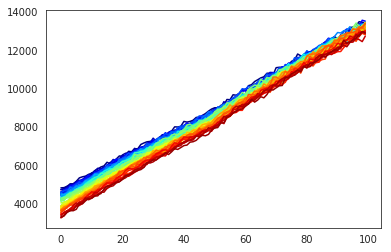

In [27]:
import matplotlib.cm as cm
pid = pool_ids[-1]
A = np.load(meas_path + 'A_' + pid + '.npy')
Q, N, R = A.shape
for r in range(R):
    plt.plot(A[:,2,r], c = cm.jet(r/R))

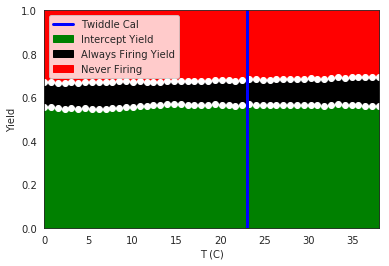

In [44]:
afs = np.ndarray(R)
nfs = np.ndarray(R)
neffs = np.ndarray(R)
for r in range(R):
    tercepts, af, nf, neff = interpret_yield(A[:,:,r], SAMPLE_PTS)
    afs[r] = af
    nfs[r] = nf
    neffs[r] = neff
plt.fill_between(MEAS_TS, (neffs)/N, [0]*R, color = 'g', label = 'Intercept Yield')
plt.plot(MEAS_TS, neffs/N, 'wo')
plt.fill_between(MEAS_TS, (neffs + afs)/N, neffs/N, color = 'k', label = 'Always Firing Yield')
plt.plot(MEAS_TS, (neffs+afs)/N, 'wo')
plt.fill_between(MEAS_TS, [1]*R, (neffs + afs)/N, color = 'r', label = 'Never Firing')
plt.axvline(23, color = 'b', linewidth = 3, label = 'Twiddle Cal')
plt.ylim([0,1])
plt.xlim([MEAS_TS[-1], MEAS_TS[0]])
plt.legend()
plt.xlabel('T (C)')
plt.ylabel('Yield')
plt.grid()

In [45]:
c = open_connection()

Connected to TestEquity M106 with port 0


In [47]:
write_setpoint(c, 23)

True

839


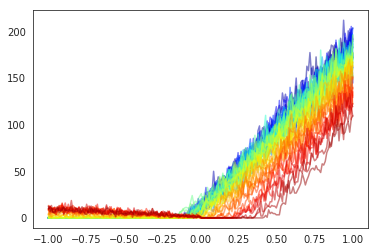

In [63]:
from matplotlib import cm
n = int(np.random.rand()*N)
print(n)
for r in range(R):
    plt.plot(SAMPLE_PTS, A[:,n,r], color = cm.jet(r/R), alpha = 0.5)

Yield for 1024 total neurons:
573.0 neurons fire with intercepts (55.9%)
142.0 neurons fire without intercepts (13.8%)
In total, 715.0 neurons fire (69.8%)
309.0 neurons never fire (30.1%)


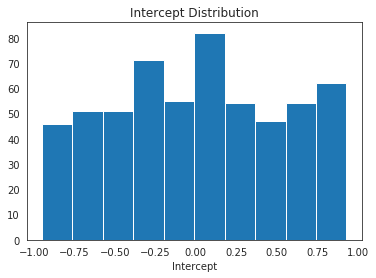

In [69]:
interpret_yield(A[:,:,1], SAMPLE_PTS, printo = True)

In [43]:
for r, Tset in enumerate(MEAS_TS):
    if(not measured[r]):
        print(str(np.sum(measured)/R*100) + "% completed")

        print("Setting temperature to " + str(Tset) + " C")
        timeout = True
        counter = 0
        while(timeout):
            timeout, avg_temp, std_temp = set_temp(Tset, INST)
            counter += 1
            if (counter > 4):
                timeout = False
        T_avg[r] = avg_temp
        T_std[r] = std_temp

        np.save('T_avg' + m_str, T_avg)
        np.save('T_std' + m_str, T_std)
        
        A1, fs1 = measure_tuning_curves(hal, ps, SAMPLE_PTS[:100], dacs= dacs, hold_time = HOLD_TIME)
        A2, fs2 = measure_tuning_curves(hal, ps, SAMPLE_PTS[100:], dacs= dacs, hold_time = HOLD_TIME)
        fs = np.concatenate((fs1, fs2))
        AA = np.ndarray((Q, N))
        AA[:100, :] = A1
        AA[100:, :] = A2

        A[:,:,r] = AA
        np.save('A' + m_str, A)
        np.save('fs' + m_str, fs)
        measured[r] = 1

0.0% completed
Setting temperature to 38.0 C
Wrote new setpoint, now waiting for stability
Timeout
Average Temp is 31.14+-0.191 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 38.0 C
Average Temp is 37.95+-0.027 C
begin sweeping -- measurement time: 200 s
done sweeping
begin sweeping -- measurement time: 200 s
done sweeping
2.0% completed
Setting temperature to 37.224489795918366 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 37.224489795918366 C
Average Temp is 37.30+-0.013 C
begin sweeping -- measurement time: 200 s
done sweeping
begin sweeping -- measurement time: 200 s
done sweeping
4.0% completed
Setting temperature to 36.44897959183673 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 36.44897959183673 C
Average Temp is 36.43+-0.009 C
begin sweeping -- measurement time: 200 s
done sweeping
begin sweeping -- measurement time: 200 s
done sweeping
6.0% completed
Setting tempera

begin sweeping -- measurement time: 200 s
done sweeping
begin sweeping -- measurement time: 200 s
done sweeping
54.0% completed
Setting temperature to 17.06122448979592 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 17.06122448979592 C
Average Temp is 17.00+-0.056 C
begin sweeping -- measurement time: 200 s
done sweeping
begin sweeping -- measurement time: 200 s
done sweeping
56.00000000000001% completed
Setting temperature to 16.285714285714285 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 16.285714285714285 C
Average Temp is 16.28+-0.029 C
begin sweeping -- measurement time: 200 s
done sweeping
begin sweeping -- measurement time: 200 s
done sweeping
57.99999999999999% completed
Setting temperature to 15.510204081632654 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 15.510204081632654 C
Average Temp is 15.46+-0.097 C
begin sweeping -- measurement time: 200 s
done sweeping
be

# Identity Decoding for 10x10 Pool

In [8]:
# Folder Path for these Measurements
path = 'identity0/'
specs_path = path + 'specs/'
cals_path = path + 'cals/'
meas_path = path + 'meas/'
if (not os.path.isdir(path)):
    os.mkdir(path)
if (not os.path.isdir(specs_path)):
    os.mkdir(specs_path)
if (not os.path.isdir(cals_path)):
    os.mkdir(cals_path)
if (not os.path.isdir(meas_path)):
    os.mkdir(meas_path)

# Temperature Cycle Information
ROOM_TEMP = 23.0 # Where twiddle bits are calibrated
MAX_TEMP = 38.0
MIN_TEMP = 0.0
R = 50    # Number of measured temperatures
MEAS_TS = np.linspace(MAX_TEMP, MIN_TEMP, R)
np.save(specs_path + 'R', R)
np.save(specs_path + 'Tarr', MEAS_TS)

# Pool Specifications for multiple pools
N_pools = 1
D = 1
X = 10
Y = 10
N_neurs = Xs*Ys
LY, LX = (0,0)
pool_ids = np.array(['id10x10'])
np.save(specs_path + 'X', X)
np.save(specs_path + 'Y', Y)
np.save(specs_path + 'N_neurs', N_neurs)
np.save(specs_path + 'N_pools', N_pools)
np.save(specs_path + 'pool_ids', pool_ids)

# Tuning Curve Settings
Q = 100    # Number of sampled input frequencies
HOLD_TIME = 2
SAMPLE_PTS = np.linspace(-1, 1, Q).reshape((Q,1))
np.save(specs_path + 'Q', Q)
np.save(specs_path + 'HOLD_TIME', HOLD_TIME)
np.save(specs_path + 'x_in', SAMPLE_PTS)

exp_time = R*(Q*N_pools*HOLD_TIME) + (MAX_TEMP - MIN_TEMP)*40
print('Collecting tuning curves for ' + str(N_pools) + ' Pool Sizes at ' + str(R) + ' Temperatures and ' + str(Q) + ' Input Values')
print("Expected Measurement Time: " + str(exp_time/60) + " min")
print(str(exp_time/3600) + " hours")

INST = ut.open_connection()

Expected Measurement Time: 192.0 min
3.2 hours
Connected to TestEquity M106 with port 502


In [9]:
# Go to room temperature for initial calibration
timeout = True
print("Going to Room Temperature")
while(timeout):
    timeout, avg_temp, std_temp = ut.set_temp(ROOM_TEMP, INST)
print()

#Collect the old pool-specs from previous 10x10 measurement run
POOL_ID = '10x10'
old_cals_path = 'several0/cals/'
bias = np.load(old_cals_path + 'biases_' + POOL_ID + '.npy')
TPM = np.load(old_cals_path + 'TPM_' + POOL_ID + '.npy')
dacs = np.load(old_cals_path + 'dacs_' + POOL_ID + '.npy').item()

ps, dacs, hal = ut.initialize_and_calibrate(10, X, LY, LX, twiddle = False)

ps.biases = bias
ps.TPM = TPM

Going to Room Temperature
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 23.0 C
Average Temp is 22.94+-0.026 C

HAL Initialized
Tap Points Optimized
Fmax Optimized


In [10]:
# Save initial empty tuning curve matrices:
for ind, pid in enumerate(pool_ids):
    A = np.ndarray((Q, N_neurs[ind], R))
    np.save(meas_path + 'A_' + pid, A)

# Have we measured this temperature already?
measured = [False]*R

In [12]:
INST = ut.open_connection()

Connected to TestEquity M106 with port 502


In [14]:
for r, Tset in enumerate(MEAS_TS):
    if (not measured[r]):
        print(str(np.sum(measured)/R*100) + "% completed")

        print("Setting temperature to " + str(Tset) + " C")
        timeout = True
        counter = 0
        while(timeout):
            timeout, avg_temp, std_temp = ut.set_temp(Tset, INST)
            counter += 1
            if (counter > 3):
                timeout = False
        for ind, pid in enumerate(pool_ids):
            hal = HAL()
            print("Measuring " + pid + " at " + str(Tset) + ' C')
            D = np.eye(100)
            yhat, freqs = ut.measure_output_decoder(hal, ps, SAMPLE_PTS, D, dacs=dacs, training_hold_time = HOLD_TIME)
            
            A = np.load(meas_path + 'A_' + pid + '.npy')
            A[:,:,r] = yhat
            np.save(meas_path + 'A_' + pid, A)
            np.save(meas_path + 'fs_' + pid, freqs)
        measured[r] = True

0.0% completed
Setting temperature to 38.0 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 38.0 C
Average Temp is 38.02+-0.028 C
Measuring id10x10 at 38.0 C
1 --> 100
Calling Map
2.0% completed
Setting temperature to 37.224489795918366 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 37.224489795918366 C
Average Temp is 37.24+-0.031 C
Measuring id10x10 at 37.224489795918366 C
1 --> 100
Calling Map
4.0% completed
Setting temperature to 36.44897959183673 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 36.44897959183673 C
Average Temp is 36.42+-0.018 C
Measuring id10x10 at 36.44897959183673 C
1 --> 100
Calling Map
6.0% completed
Setting temperature to 35.673469387755105 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 35.673469387755105 C
Average Temp is 35.68+-0.016 C
Measuring id10x10 at 35.673469387755105 C
1 --> 100
Calling Map
8.0% completed
Se

64.0% completed
Setting temperature to 13.183673469387756 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 13.183673469387756 C
Average Temp is 13.21+-0.104 C
Measuring id10x10 at 13.183673469387756 C
1 --> 100
Calling Map
66.0% completed
Setting temperature to 12.408163265306122 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 12.408163265306122 C
Average Temp is 12.43+-0.051 C
Measuring id10x10 at 12.408163265306122 C
1 --> 100
Calling Map
68.0% completed
Setting temperature to 11.632653061224492 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 11.632653061224492 C
Average Temp is 11.62+-0.077 C
Measuring id10x10 at 11.632653061224492 C
1 --> 100
Calling Map
70.0% completed
Setting temperature to 10.857142857142858 C
Wrote new setpoint, now waiting for stability
Temperature stable within 0.15 C of 10.857142857142858 C
Average Temp is 10.82+-0.104 C
Measuring id10x10 at 10.85714285

Text(0,0.5,'Spike Rate (Hz)')

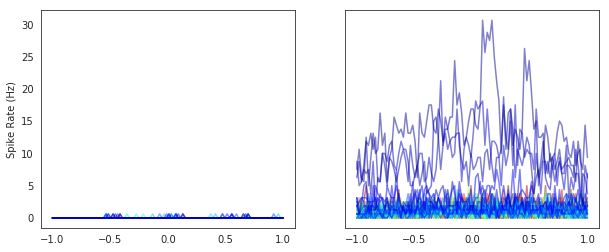

In [111]:
index = 0
fig, ax = plt.subplots(1,2, figsize = (10,4), sharey=True)
x = np.linspace(-1,1,100)
for r in range(50):
    ax[0].plot(x, A[:,index,r], c=cm.jet(1-r/50), alpha = 0.5)
    ax[1].plot(x, A_old[:,index,r], c=cm.jet(1-r/50), alpha = 0.5)
ax[0].set_ylabel('Spike Rate (Hz)')

In [22]:
import matplotlib.cm as cm

In [46]:
A_old = np.load('several0/meas/A_10x10.npy')

In [107]:
sys.path.append('PINT/Module/')
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
%autoreload

In [109]:
from PINT import tuning_curves

ImportError: cannot import name 'tuning_curves' from 'PINT' (unknown location)

# Change FPGA Duty Cycle -> This is a neuron that never fires, so tuning curve should be zero

In [2]:
ps, dacs, hal = ut.initialize_and_calibrate(60, 60, 0, 0, twiddle=False)

HAL Initialized
Tap Points Optimized
Fmax Optimized


In [3]:
A_new, fs_new = ut.measure_tuning_curves(hal, ps, np.linspace(-1,1,10).reshape(-1,1), dacs = dacs, training_hold_time = 2)

1 --> 1
Calling Map


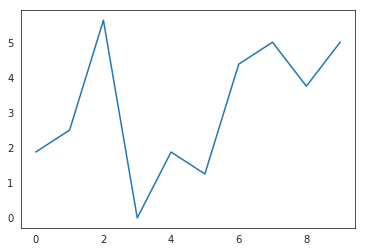

In [4]:
plt.plot(A_new[:,0]) #old core --> pretty bad

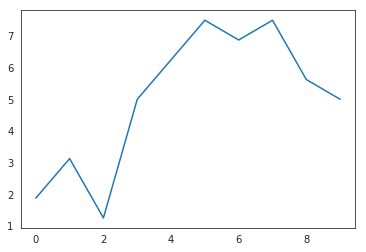

In [4]:
plt.plot(A_new[:,0]) #90 --> pretty bad

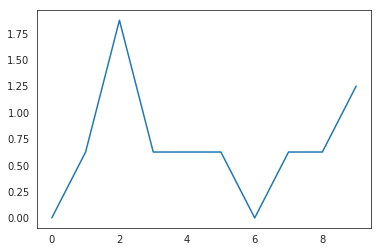

In [4]:
plt.plot(A_new[:,0]) #10 --> best so far!

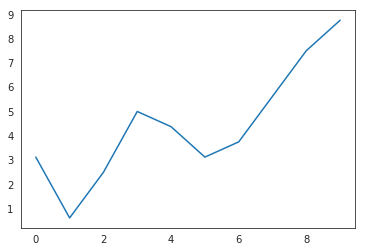

In [4]:
plt.plot(A_new[:,0]) #80 --> worse

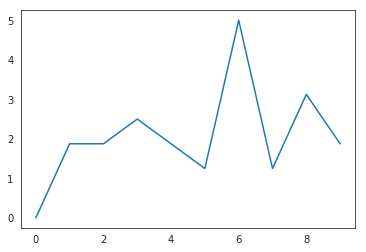

In [10]:
plt.plot(A_new[:,0]) #20 --> better